## 1.Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import string
import re      #RegEx in Python supports various things like Modifiers, Identifiers, and White space characters.

## 2.Import Datasets

In [ ]:
eng_fre_data=pd.read_csv("eng_-french.csv")
eng_fre_data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


## 3.Data Understanding

In [ ]:
eng_fre_data.shape

(175621, 2)

In [ ]:
eng_fre_data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [ ]:
eng_fre_data.describe()

,English words/sentences,French words/sentences
count,175621,175621
unique,123100,165975
top,I can't tell you how happy I am that you've co...,C'est bizarre.
freq,32,9


In [ ]:
eng_fre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


## 4. Data Preprocessing

In [ ]:
from unicodedata import normalize  #It provides access to Unicode Character Database(UCD) 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences #It is used to ensure that all sequences in a list have the same length.

In [ ]:
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from string import punctuation
from tensorflow.keras.utils import to_categorical # 

In [ ]:
# Limit the sentences to 10.00 to avoid exceding the available RAM space
# Build a generator to avoid this issue

total_sentences = 10000

# Load the dataset
eng_fre_data= pd.read_csv("eng_-french.csv", nrows = total_sentences)

# What proportion of the sentences will be used for the test set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

print(f'{total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
print(f'{train_test_threshold} "parallel sentences" will be used to train the model')
print(f'{total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

10000 "parallel sentences" will be loaded (original sentence + its translation)
9000 "parallel sentences" will be used to train the model
1000 "parallel sentences" will be used to test the model


### 4.1 Shuffle the dataset

In [ ]:
eng_fre_data= eng_fre_data.sample(frac=1, random_state=0) # Returns all the rows in random order
eng_fre_data.iloc[1000:1010]

,English words/sentences,French words/sentences
1554,Let me die.,Laisse-moi mourir.
2087,He's a slob.,C'est un flemmard.
5470,I have to try.,Il faut que j'essaie.
2363,I was naive.,Je fus crédule.
7570,He is bankrupt.,Il est en faillite.
6427,That's a fact.,C'est un fait.
1651,Talk to me!,Parlez-moi !
4164,Keep talking.,Continuez de parler.
1231,I broke it.,Je l'ai cassée.
9232,Tom is a judge.,Tom est juge.


###  4.2 Clean the string

In [ ]:
def clean(string):
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

In [ ]:
# Clean the sentences
eng_fre_data["English words/sentences"] = eng_fre_data["English words/sentences"].apply(lambda x: clean(x))
eng_fre_data["French words/sentences"] = eng_fre_data["French words/sentences"].apply(lambda x: clean(x))

In [ ]:
eng_fre_data

,English words/sentences,French words/sentences
9394,we know enough,nous en savons assez
898,stay calm,garde ton sang froid
2398,i won t cry,je ne pleurerai pas
5906,i m not happy,je ne suis pas contente
2343,i want that,moi je veux ça
...,...,...
9225,tom hated that,tom détestait ça
4859,are you ready,es tu prête
3264,can i try it,je peux essayer
9845,you ve done it,tu l as fait


In [ ]:
# Select one part of the dataset
eng_fre_data= eng_fre_data.values

In [ ]:
eng_fre_data= eng_fre_data[:total_sentences] #[:] syntax is a slice with the default start and end values 
eng_fre_data

array([['we know enough', 'nous en savons assez'],
       ['stay calm', 'garde ton sang froid'],
       ['i won t cry', 'je ne pleurerai pas'],
       ...,
       ['can i try it', 'je peux essayer'],
       ['you ve done it', 'tu l as fait'],
       ['shall we go', 'y allons nous']], dtype=object)

### 4.3 Split into train/test

In [ ]:
train, test = eng_fre_data[:train_test_threshold], eng_fre_data[train_test_threshold:]
train.shape

(9000, 2)

In [ ]:
test.shape

(1000, 2)

In [ ]:
# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "French", "English"

In [ ]:
# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [ ]:
# Display the result after cleaning
pd.DataFrame(eng_fre_data[1000:1010])

,0,1
0,let me die,laisse moi mourir
1,he s a slob,c est un flemmard
2,i have to try,il faut que j essaie
3,i was naive,je fus crédule
4,he is bankrupt,il est en faillite
5,that s a fact,c est un fait
6,talk to me,parlez moi
7,keep talking,continuez de parler
8,i broke it,je l ai cassée
9,tom is a judge,tom est juge


### 4.4 Fit a tokenizer

In [ ]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

  # max sentence length
def max_len(lines):
    return max(len(line.split()) for line in lines)

    # encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X

In [ ]:
 # one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

* **One hot encoding** can be defined as the essential process of converting the categorical data variables to be provided to machine and deep learning algorithms which in turn improve predictions as well as classification accuracy of a model.

### 4.5 Prepare target tokenizer

In [ ]:
tar_tokenizer = create_tokenizer(eng_fre_data[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(eng_fre_data[:, idx_tar])
print(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
print(f'Target ({target_str}) Max Length: {tar_length}')


Target (English) Vocabulary Size: 2099
Target (English) Max Length: 5


### 4.6 Prepare source tokenizer

In [ ]:
src_tokenizer = create_tokenizer(eng_fre_data[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(eng_fre_data[:, idx_src])
print(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
print(f'Source ({source_str}) Max Length: {src_length}\n')


Source (French) Vocabulary Size: 4039
Source (French) Max Length: 12



### 4.7 Prepare training data

In [ ]:
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

### 4.8 Prepare test data

In [ ]:
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)

## 5.Model Building

### 5.1 Building the architecture

In [ ]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units,activation='tanh'))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True,activation='tanh'))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 

model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)


* **Embedding Layer** = It is used for Neural Network to work on Text Data. (Only be used as the first layer in a model.)
* **RepeatVector**    = Repeats the input n times.
* **TimeDistributed** = This wrapper allows to apply a layer to every temporal slice of an input.
* If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
* If  return_sequences is used to return the last output.

### 5.2 Model Compilation

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics='accuracy')

## 6. Model Training

In [ ]:
model_training= model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
127/127 [==============================] - 15s 79ms/step - loss: 4.3567 - accuracy: 0.4132 - val_loss: 3.5013 - val_accuracy: 0.4451
Epoch 2/200
127/127 [==============================] - 7s 57ms/step - loss: 3.3243 - accuracy: 0.4527 - val_loss: 3.3065 - val_accuracy: 0.4518
Epoch 3/200
127/127 [==============================] - 7s 56ms/step - loss: 3.1205 - accuracy: 0.4699 - val_loss: 3.1374 - val_accuracy: 0.4747
Epoch 4/200
127/127 [==============================] - 7s 57ms/step - loss: 2.9319 - accuracy: 0.4865 - val_loss: 3.0129 - val_accuracy: 0.4884
Epoch 5/200
127/127 [==============================] - 7s 59ms/step - loss: 2.7933 - accuracy: 0.5009 - val_loss: 2.9316 - val_accuracy: 0.5004
Epoch 6/200
127/127 [==============================] - 7s 59ms/step - loss: 2.6783 - accuracy: 0.5141 - val_loss: 2.8602 - val_accuracy: 0.5184
Epoch 7/200
127/127 [==============================] - 7s 55ms/step - loss: 2.5578 - accuracy: 0.5338 - val_loss: 2.7756 - val_accuracy

 * Callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process
 * To avoid my neural network from overfitting by using early stopping.
 * Patience argument represents the number of epochs before stopping once your loss starts to increase (stops improving)
 * Restore_best_weights argument is used to load the model with best weights after training.

## 8. Model Evaluation

In [ ]:
model.evaluate(testX,testY)

32/32 [==============================] - 1s 20ms/step - loss: 1.7074 - accuracy: 0.7358


[1.707402229309082, 0.73580002784729]

## 7. Model Prediction

In [ ]:
def word_for_id(integer, tokenizer):# map an integer to a word
    for word, index in tokenizer.word_index.items(): #A dictionary of words and their uniquely assigned integers.
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):# generate target from a source sequence
    prediction = model.predict(source)[0]
    integers = [np.argmax(vector) for vector in prediction] #Returns the indices of the maximum values along an axis
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [ ]:
def compare_prediction(model, tokenizer, sources, raw_dataset, limit=5):
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break

### 7.1 Test on some training sequences

In [ ]:
print('### Result on the Training Set ###')
print('\n')
compare_prediction(model, tar_tokenizer, trainX, train)

### Result on the Training Set ###


FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

nous en savons assez           we know enough            we know enough
garde ton sang froid           stay calm                 stay calm
je ne pleurerai pas            i won t cry               i won t cry
je ne suis pas contente        i m not happy             i m not happy
moi je veux ça                 i want that               i want that
j étais tellement heureuse     i was so happy            i was so happy


### 7.2 Test on some test sequences

In [ ]:
print('### Result on the Test Set ###')
print('\n')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Test Set ###


FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

ils ont abandonné              they gave up              they gave up
rappelle moi                   call me back              marry me
je veux essayer                i want to try             i want to wait
ça fonctionne bien             it works well             it works good
grimpe dans la camionnette     get in the van            get in the van
je suis mince                  i m thin                  i m stupid


## 9.Model Performace

### 9.1 Model Accuracy Peformance

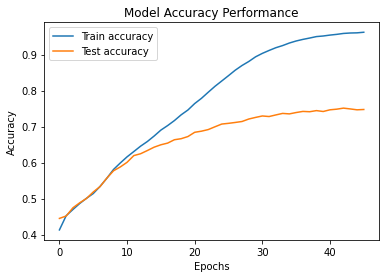

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_training.history['accuracy'],label='Train accuracy')

plt.plot(model_training.history['val_accuracy'],label='Test accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Performance')
plt.legend()
plt.show()

### 9.2 Model Loss Performance

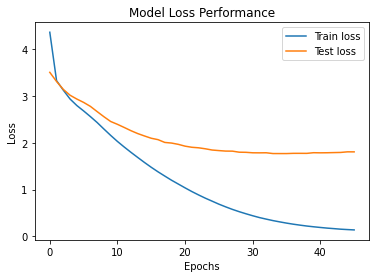

In [ ]:
plt.plot(model_training.history['loss'],label='Train loss')

plt.plot(model_training.history['val_loss'],label='Test loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Performance')
plt.legend()
plt.show()